# COVID-19 prediction

## Import data and packages

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')


In [120]:
df = pd.read_csv('covid.csv')

In [121]:
df.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
0,ME,2021/01/20,3,28,8,2,29,8,7.0,38,...,NaN,0,NaN,0,NaN,0,47.0,38,54.0,38
1,SD,2021/01/20,2,60,3,2,60,3,34.0,62,...,NaN,0,NaN,0,NaN,0,33.0,62,83.0,62
2,MS,2021/01/17,12,95,2,16,91,2,10.0,107,...,NaN,0,NaN,0,NaN,0,78.0,107,180.0,107
3,CT,2021/01/13,4,35,1,4,35,1,31.0,39,...,NaN,0,NaN,0,NaN,0,196.0,39,335.0,39
4,MT,2021/01/13,10,56,1,11,55,1,18.0,66,...,NaN,0,NaN,0,NaN,0,12.0,21,40.0,21


## Initial EDA

In [122]:
# number of rows and columns
df.shape

(52445, 135)

### Lets filter out some features

Lets better understand the data types in our dataset

In [123]:
# how many columns per data type
df.dtypes.value_counts()

float64    77
int64      56
object      2
dtype: int64

What are our object columns exactly 

In [124]:
# print object columns
df.select_dtypes('object').columns


Index(['state', 'date'], dtype='object')

#### We can convert 'state' to string and 'date' to a time stamp

In [128]:
# convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# convert state column to string 
df['state'] = df['state'].astype(str)


#### Normalize "therapeutics" by beds_used_coverage

In [129]:
# divide all columns with "therapeutics" in the name by the "beds_coverage" column
cols_thera = [col for col in df.columns if 'therapeutic' in col]
for col in cols_thera:
    df[col] = df[col]/df['inpatient_beds_coverage']

#### Normalize columns by their relative counterpart

In [130]:
# find all column names pairs of ("col", "col_coverage")
cols_coverage = [col for col in df.columns if 'coverage' in col]

# col reg as cols_coverage without "_coverage"
cols_reg = [col.replace('_coverage', '') for col in cols_coverage]

In [131]:
for i in range(len(cols_reg)):
    df[cols_reg[i]] = df[cols_reg[i]]/df[cols_coverage[i]]

#### Remove utilization cols

In [132]:
# cols that have "numerator" in the name but not "numerator" or "denominator"
cols_utilization = [col for col in df.columns if 'utilization' in col and 'numerator' not in col and 'denominator' not in col]

In [133]:
# drop cols_utilization
df.drop(cols_utilization, axis=1, inplace=True)

#### Remove geocoded_state

In [134]:
# drop "geocode_state"
df.drop('geocoded_state', axis=1, inplace=True)

#### Remove columns which have a majority of Nan

In [135]:
def nan_cols(df, pct):
    """function to return columns with more than pct % of missing values"""
    lst = df.columns[df.isnull().mean() > pct]
    return lst

In [136]:
# columns with more than 50% of missing values
nan50 = nan_cols(df, 0.5)

# drop columns with more than 50% of missing values
df.drop(nan50, axis=1, inplace=True)

#### Removing data related to influenza as we are working specifically on this data 

In [137]:
# how many column names with "influenza" in it
influenza = df.columns[df.columns.str.contains('influenza')].tolist()
influenza

['icu_patients_confirmed_influenza',
 'icu_patients_confirmed_influenza_coverage',
 'previous_day_admission_influenza_confirmed',
 'previous_day_admission_influenza_confirmed_coverage',
 'previous_day_deaths_covid_and_influenza',
 'previous_day_deaths_covid_and_influenza_coverage',
 'previous_day_deaths_influenza',
 'previous_day_deaths_influenza_coverage',
 'total_patients_hospitalized_confirmed_influenza',
 'total_patients_hospitalized_confirmed_influenza_and_covid',
 'total_patients_hospitalized_confirmed_influenza_and_covid_coverage',
 'total_patients_hospitalized_confirmed_influenza_coverage']

In [138]:
# drop influenza columns
df.drop(influenza, axis=1, inplace=True)

#### Remove the columns with "coverage"

In [139]:
# create a df wihtout columns that have "coverage" in it
df = df[df.columns[~df.columns.str.contains('coverage')]]


In [140]:
# print lal variables with correlation >0.8 but not equal to 1
corr = df.corr()
# pairs above 0.7
pairs = corr[corr > 0.95][corr != 1].stack().reset_index().sort_values(by=0, ascending=False)
pairs

,level_0,level_1,0
50,adult_icu_bed_utilization_denominator,adult_icu_bed_covid_utilization_denominator,0.999836
39,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization_denominator,0.999836
20,percent_of_inpatients_with_covid_numerator,inpatient_bed_covid_utilization_numerator,0.999758
27,inpatient_bed_covid_utilization_numerator,percent_of_inpatients_with_covid_numerator,0.999758
29,inpatient_bed_covid_utilization_denominator,inpatient_beds_utilization_denominator,0.999106
16,inpatient_beds_utilization_denominator,inpatient_bed_covid_utilization_denominator,0.999106
9,inpatient_beds_utilization_numerator,percent_of_inpatients_with_covid_denominator,0.999066
21,percent_of_inpatients_with_covid_denominator,inpatient_beds_utilization_numerator,0.999066
14,inpatient_beds_utilization_denominator,inpatient_beds_utilization_numerator,0.992918
8,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,0.992918


In [141]:
# how many unique variables in pairs
pairs['level_0'].nunique()

16

#### Remove "pediatrics"

In [142]:
# remove columns with "pediatrics" in it
df.drop(df.columns[df.columns.str.contains('pediatric')], axis=1, inplace=True)

Should we maybe do some sort of Holistic Regression or whatnot to reduce the number of variables ? or do it manually ? <br>
Do we really want to keep pediatrics ?

#### Remove "states" that are actually territories

In [143]:
# drop rows with number of points per state < 900
df = df.groupby('state').filter(lambda x: len(x) > 900)

#  how many states in df
df['state'].nunique()

53

In [144]:
# remove VI, PR and AS from df
df = df[~df['state'].isin(['VI', 'PR', 'AS'])]

#  how many states in df
df['state'].nunique()

51

## Remove columns with still too many NaNs

In [145]:
# number of Nan values in each column as a dataframe
df.isna().sum().to_frame().sort_values(by=0, ascending=False).head(10)

,0
on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses,19640
previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used,19623
on_hand_supply_therapeutic_b_bamlanivimab_courses,15321
previous_week_therapeutic_b_bamlanivimab_courses_used,15285
on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses,15088
previous_week_therapeutic_a_casirivimab_imdevimab_courses_used,15087
previous_day_admission_adult_covid_confirmed_unknown,7400
previous_day_admission_adult_covid_suspected_unknown,7398
previous_day_admission_adult_covid_suspected_18-19,7253
previous_day_admission_adult_covid_confirmed_18-19,7253


We can remove all the columns with therapeutic as they have more than 15,000 NaN

In [146]:
# print columns with "therapeutic" in column name
therapeutic = df.columns[df.columns.str.contains('therapeutic')].tolist()
therapeutic

['on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses',
 'on_hand_supply_therapeutic_b_bamlanivimab_courses',
 'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses',
 'previous_week_therapeutic_a_casirivimab_imdevimab_courses_used',
 'previous_week_therapeutic_b_bamlanivimab_courses_used',
 'previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used']

In [147]:
# drop columns with "therapeutic" in column name
df.drop(therapeutic, axis=1, inplace=True)

#### Drop all values for dates that do not have all states

<AxesSubplot:xlabel='date'>

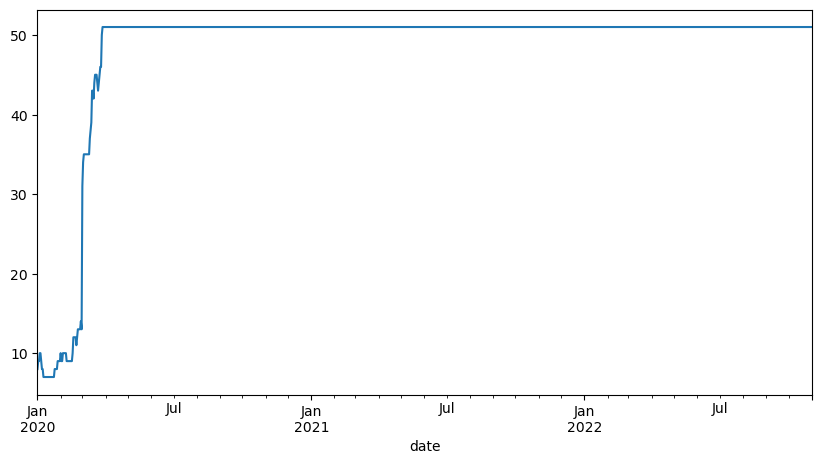

In [148]:
# how many unique states per date
# increase plot size
plt.figure(figsize=(10,5))
df.groupby('date')['state'].nunique().plot()

In [149]:
# which date are there less than 50 states
df.groupby('date')['state'].nunique().loc['2020-03-27']

50

In [150]:
df.groupby('date')['state'].nunique().loc['2020-03-28']

51

In [151]:
# convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [152]:
df = df.set_index('date')
df = df.sort_index(ascending=True, axis=0)

In [153]:
# drop values before 2020-03-28
df = df.loc['2020-03-28':]

In [154]:
df.head()

,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,...,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid
date,,,,,,,,,,,,,,,,,,,,,
2020-03-28,IN,0,0,15,0,0,15,0.333333,109.466667,61.933333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071429
2020-03-28,OR,0,0,7,0,0,7,0.000000,83.571429,37.285714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-03-28,ND,0,0,3,0,0,3,0.000000,66.666667,7.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-03-28,DC,0,0,2,0,0,2,NaN,501.500000,342.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-03-28,WV,0,0,7,0,0,7,0.000000,81.428571,36.571429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857


In [155]:
# output df to csv
df.to_csv('covid_clean.csv', index=False)

#### Drop percent column

In [156]:
# print columns with percent in name and not numerator or denominator
percent = df.columns[df.columns.str.contains('percent')].tolist()
percent

['percent_of_inpatients_with_covid',
 'percent_of_inpatients_with_covid_numerator',
 'percent_of_inpatients_with_covid_denominator']

In [157]:
# drop first column of percent 
df.drop(percent[0], axis=1, inplace=True)

## Data imputation

In [158]:
# use KNN imputer to fill missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

In [159]:
# df = pd.read_csv('covid_clean_imputted.csv')

In [160]:
# use KNN imputer to fill missing numeric values
df.iloc[:, 2:] = imputer.fit_transform(df.iloc[:, 2:])
# df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [161]:
#  number of Nan values in the df
df.isna().sum().sum()

0

In [162]:
# KNN imputer for string values
# df['state'] = df['state'].fillna(df['state'].mode()[0])

In [163]:
df.head()

,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,...,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid
date,,,,,,,,,,,,,,,,,,,,,
2020-03-28,IN,0,0.0,15.0,0.0,0.0,15.0,0.333333,109.466667,61.933333,...,0.00,0.008696,0.008696,0.008333,0.025362,0.033696,0.025000,0.008696,0.000000,0.071429
2020-03-28,OR,0,0.0,7.0,0.0,0.0,7.0,0.000000,83.571429,37.285714,...,0.09,0.180000,0.050000,0.000000,0.033333,0.040000,0.083333,0.140000,0.244444,0.000000
2020-03-28,ND,0,0.0,3.0,0.0,0.0,3.0,0.000000,66.666667,7.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244444,0.000000
2020-03-28,DC,0,0.0,2.0,0.0,0.0,2.0,0.225000,501.500000,342.500000,...,0.00,0.000000,0.000000,0.000000,0.050000,0.166667,0.016667,0.083333,0.107143,0.000000
2020-03-28,WV,0,0.0,7.0,0.0,0.0,7.0,0.000000,81.428571,36.571429,...,0.09,0.230000,0.100000,0.000000,0.033333,0.040000,0.163333,0.140000,0.244444,0.142857


In [43]:
# # replace the row number with the date
# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')

In [44]:
# #  sort the index by date in ascending order and then by country in descending order 
# df = df.sort_index(ascending=True, axis=0)

In [164]:
# output df to csv
df.to_csv('covid_clean_imputted.csv', index=True)

### Aggregate dataset by date

In [166]:
# group df by index 
df = df.groupby('date').sum()

In [167]:
df.shape

(950, 47)

#### Coverage for _yes, _no, _not_reported

In [168]:
#  variables with '_yes' in the name
cols_yes = [col for col in df.columns if '_yes' in col]
cols_nr = [col for col in df.columns if '_not_reported' in col]
cols_no = [col for col in df.columns if '_no' in col and col not in cols_nr]

for i in range(2):
    df[cols_yes[i]] = df[cols_yes[i]]/(df[cols_yes[i]] + df[cols_no[i]] + df[cols_nr[i]])
    df[cols_no[i]] = df[cols_no[i]]/(df[cols_yes[i]] + df[cols_no[i]] + df[cols_nr[i]])
    df[cols_nr[i]] = df[cols_nr[i]]/(df[cols_yes[i]] + df[cols_no[i]] + df[cols_nr[i]])

#### Utilization for num/denom

In [169]:
cols_num = [col for col in df.columns if '_numerator' in col]
cols_denom = [col for col in df.columns if '_denominator' in col]

In [170]:
# df[cols_num] = df[cols_num].div(df[cols_denom], axis=0)
for i in range(len(cols_num)):
    df[cols_num[i]] = df[cols_num[i]]/df[cols_denom[i]]

In [171]:
# drop cols_denom
df.drop(cols_denom, axis=1, inplace=True)

In [172]:
# replace "numerator" in column names with "utilization"
df.columns = df.columns.str.replace('numerator', 'utilization')

In [173]:
# export as csv
df.to_csv('covid_clean_imputted_aggregated.csv', index=True)

# VIF

In [174]:
df_ = df[['critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported',
       'critical_staffing_shortage_anticipated_within_week_yes',
       'critical_staffing_shortage_anticipated_within_week_no',
       'critical_staffing_shortage_anticipated_within_week_not_reported',
       'hospital_onset_covid', 'inpatient_beds', 'inpatient_beds_used',
       'inpatient_beds_used_covid',
       'previous_day_admission_adult_covid_confirmed',
       'previous_day_admission_adult_covid_suspected',
       'staffed_adult_icu_bed_occupancy',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid',
       'staffed_icu_adult_patients_confirmed_covid',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
       'total_adult_patients_hospitalized_confirmed_covid',
       'total_staffed_adult_icu_beds',
       'inpatient_beds_utilization_utilization',
       'percent_of_inpatients_with_covid_utilization',
       'inpatient_bed_covid_utilization_utilization',
       'adult_icu_bed_covid_utilization_utilization',
       'adult_icu_bed_utilization_utilization',
       'previous_day_admission_adult_covid_confirmed_18-19',
       'previous_day_admission_adult_covid_confirmed_20-29',
       'previous_day_admission_adult_covid_confirmed_30-39',
       'previous_day_admission_adult_covid_confirmed_40-49',
       'previous_day_admission_adult_covid_confirmed_50-59',
       'previous_day_admission_adult_covid_confirmed_60-69',
       'previous_day_admission_adult_covid_confirmed_70-79',
       'previous_day_admission_adult_covid_confirmed_80+',
       'previous_day_admission_adult_covid_confirmed_unknown',
       'previous_day_admission_adult_covid_suspected_18-19',
       'previous_day_admission_adult_covid_suspected_20-29',
       'previous_day_admission_adult_covid_suspected_30-39',
       'previous_day_admission_adult_covid_suspected_40-49',
       'previous_day_admission_adult_covid_suspected_50-59',
       'previous_day_admission_adult_covid_suspected_60-69',
       'previous_day_admission_adult_covid_suspected_70-79',
       'previous_day_admission_adult_covid_suspected_80+',
       'previous_day_admission_adult_covid_suspected_unknown']]

In [175]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_.values, i)
                          for i in range(len(df_.columns))]

In [176]:
vif_features = vif_data.sort_values(by="VIF",ascending=False)
vif_features

,feature,VIF
2,critical_staffing_shortage_today_not_reported,5.653332e+07
5,critical_staffing_shortage_anticipated_within_...,5.651664e+07
18,inpatient_beds_utilization_utilization,4.223471e+04
8,inpatient_beds_used,4.125496e+04
7,inpatient_beds,3.512014e+04
22,adult_icu_bed_utilization_utilization,1.690436e+04
12,staffed_adult_icu_bed_occupancy,1.139998e+04
17,total_staffed_adult_icu_beds,8.717810e+03
4,critical_staffing_shortage_anticipated_within_...,7.401827e+03
16,total_adult_patients_hospitalized_confirmed_covid,7.015022e+03


In [177]:
vif_features = vif_features["feature"][0:10]

In [178]:
df_ = df_.drop(columns=vif_features)

In [179]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_.values, i)
                          for i in range(len(df_.columns))]

In [180]:
vif_features = vif_data.sort_values(by="VIF",ascending=False)
vif_features = vif_features["feature"][0:5]
df_ = df_.drop(columns=vif_features)

In [181]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_.values, i)
                          for i in range(len(df_.columns))]
vif_features = vif_data.sort_values(by="VIF",ascending=False)
vif_features

,feature,VIF
13,previous_day_admission_adult_covid_confirmed_6...,502.379298
14,previous_day_admission_adult_covid_confirmed_7...,424.740055
12,previous_day_admission_adult_covid_confirmed_5...,340.079492
22,previous_day_admission_adult_covid_suspected_6...,290.094968
23,previous_day_admission_adult_covid_suspected_7...,278.167766
6,total_adult_patients_hospitalized_confirmed_an...,255.572173
24,previous_day_admission_adult_covid_suspected_80+,195.457899
21,previous_day_admission_adult_covid_suspected_5...,192.187357
10,previous_day_admission_adult_covid_confirmed_3...,177.359180
15,previous_day_admission_adult_covid_confirmed_80+,163.887290


In [182]:
df_ = df_.drop(columns = ["critical_staffing_shortage_today_yes", "critical_staffing_shortage_today_no"])

In [183]:
df_["deaths_covid"] = df["deaths_covid"]

In [184]:
df = df_;
# export as csv
df.to_csv('covid_clean_imputted_aggregated_vif.csv', index=True)

In [185]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
vif_features = vif_data.sort_values(by="VIF",ascending=False)
vif_features

,feature,VIF
11,previous_day_admission_adult_covid_confirmed_6...,469.248309
12,previous_day_admission_adult_covid_confirmed_7...,421.792152
10,previous_day_admission_adult_covid_confirmed_5...,330.881935
20,previous_day_admission_adult_covid_suspected_6...,288.819332
21,previous_day_admission_adult_covid_suspected_7...,277.902419
4,total_adult_patients_hospitalized_confirmed_an...,250.099364
22,previous_day_admission_adult_covid_suspected_80+,192.175576
19,previous_day_admission_adult_covid_suspected_5...,189.345549
8,previous_day_admission_adult_covid_confirmed_3...,167.008767
13,previous_day_admission_adult_covid_confirmed_80+,152.505776


In [200]:
cols_susp = [col for col in df.columns if '_suspected' in col]
cols_conf = [col for col in df.columns if '_confirmed' in col]
cols_susp.pop(1); cols_conf.pop(0) #we want to keep confirmed and suspected

'total_adult_patients_hospitalized_confirmed_and_suspected_covid'

In [202]:
df = df.drop(columns=cols_susp)
df = df.drop(columns=cols_conf)

In [205]:
df.to_csv('covid_clean_imputted_aggregated_vif_FINAL.csv', index=True)

### Imputted and standardized

In [477]:
# standardize df
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

In [478]:
# export df to csv
df.to_csv('covid_clean_imputted_std_aggregated_vif.csv', index=True)

### Lets build a correlation plot of the variables in our model

In [479]:
corrM = df.corr()
corrM.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

,critical_staffing_shortage_anticipated_within_week_yes,hospital_onset_covid,inpatient_beds_used_covid,previous_day_admission_adult_covid_suspected,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization_utilization,previous_day_admission_adult_covid_confirmed_18-19,previous_day_admission_adult_covid_confirmed_20-29,previous_day_admission_adult_covid_confirmed_30-39,previous_day_admission_adult_covid_confirmed_40-49,previous_day_admission_adult_covid_confirmed_50-59,previous_day_admission_adult_covid_confirmed_60-69,previous_day_admission_adult_covid_confirmed_70-79,previous_day_admission_adult_covid_confirmed_80+,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid
critical_staffing_shortage_anticipated_within_week_yes,1.00,0.37,0.32,0.36,0.55,0.36,0.09,0.36,0.40,0.42,0.48,0.51,0.52,0.49,0.26,0.17,0.29,0.36,0.33,0.42,0.43,0.47,0.46,-0.06,-0.06
hospital_onset_covid,0.37,1.00,0.69,0.12,0.70,0.43,0.16,0.71,0.62,0.50,0.58,0.71,0.79,0.83,0.40,0.06,0.05,0.04,0.06,0.10,0.16,0.21,0.23,-0.03,0.39
inpatient_beds_used_covid,0.32,0.69,1.00,0.39,0.95,0.91,0.18,0.75,0.79,0.85,0.90,0.93,0.91,0.83,0.66,0.17,0.28,0.26,0.30,0.32,0.35,0.36,0.34,0.13,0.73
previous_day_admission_adult_covid_suspected,0.36,0.12,0.39,1.00,0.46,0.54,0.13,0.24,0.26,0.37,0.43,0.42,0.40,0.31,0.70,0.66,0.83,0.85,0.89,0.91,0.91,0.89,0.87,0.62,0.31
total_adult_patients_hospitalized_confirmed_and_suspected_covid,0.55,0.70,0.95,0.46,1.00,0.90,0.18,0.78,0.84,0.89,0.94,0.97,0.95,0.87,0.66,0.19,0.33,0.34,0.37,0.40,0.44,0.45,0.43,0.11,0.59
adult_icu_bed_covid_utilization_utilization,0.36,0.43,0.91,0.54,0.90,1.00,0.16,0.63,0.73,0.87,0.88,0.86,0.78,0.63,0.70,0.26,0.44,0.43,0.45,0.46,0.47,0.44,0.40,0.23,0.68
previous_day_admission_adult_covid_confirmed_18-19,0.09,0.16,0.18,0.13,0.18,0.16,1.00,0.23,0.21,0.19,0.19,0.19,0.18,0.17,0.20,0.07,0.18,0.17,0.13,0.13,0.13,0.15,0.14,0.04,0.14
previous_day_admission_adult_covid_confirmed_20-29,0.36,0.71,0.75,0.24,0.78,0.63,0.23,1.00,0.96,0.83,0.84,0.83,0.77,0.71,0.60,0.18,0.30,0.30,0.25,0.25,0.28,0.28,0.26,0.12,0.39
previous_day_admission_adult_covid_confirmed_30-39,0.40,0.62,0.79,0.26,0.84,0.73,0.21,0.96,1.00,0.93,0.92,0.88,0.80,0.71,0.59,0.15,0.29,0.29,0.26,0.26,0.28,0.27,0.23,0.07,0.41
previous_day_admission_adult_covid_confirmed_40-49,0.42,0.50,0.85,0.37,0.89,0.87,0.19,0.83,0.93,1.00,0.98,0.91,0.81,0.68,0.62,0.16,0.35,0.35,0.34,0.36,0.36,0.35,0.29,0.09,0.52


In [404]:
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corrM, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corrM[mask] = np.nan
(corrM
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_anticipated_within_week_yes,hospital_onset_covid,inpatient_beds_used_covid,previous_day_admission_adult_covid_suspected,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization_utilization,previous_day_admission_adult_covid_confirmed_18-19,previous_day_admission_adult_covid_confirmed_20-29,previous_day_admission_adult_covid_confirmed_30-39,previous_day_admission_adult_covid_confirmed_40-49,previous_day_admission_adult_covid_confirmed_50-59,previous_day_admission_adult_covid_confirmed_60-69,previous_day_admission_adult_covid_confirmed_70-79,previous_day_admission_adult_covid_confirmed_80+,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown
critical_staffing_shortage_today_yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
critical_staffing_shortage_today_no,0.85,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
critical_staffing_shortage_anticipated_within_week_yes,0.83,0.84,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hospital_onset_covid,0.15,-0.01,0.37,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inpatient_beds_used_covid,0.44,0.06,0.32,0.69,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
previous_day_admission_adult_covid_suspected,0.56,0.31,0.36,0.12,0.39,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
total_adult_patients_hospitalized_confirmed_and_suspected_covid,0.61,0.29,0.55,0.70,0.95,0.46,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
adult_icu_bed_covid_utilization_utilization,0.62,0.22,0.36,0.43,0.91,0.54,0.90,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
previous_day_admission_adult_covid_confirmed_18-19,0.10,0.03,0.09,0.16,0.18,0.13,0.18,0.16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
previous_day_admission_adult_covid_confirmed_20-29,0.36,0.13,0.36,0.71,0.75,0.24,0.78,0.63,0.23,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
